In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import percentileofscore
from scipy.signal import medfilt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
def mean_cov(x):
    return x.mean(axis=0), np.cov(x, rowvar=False)

def mv_normal_kl(mu0, sigma0, mu1, sigma1):
    sigma1_inv = np.linalg.inv(sigma1)
    mean_diff = mu1 - mu0
    d = mu1.size
    tr = np.trace(sigma1_inv.dot(sigma0))
    means = mean_diff.dot(sigma1_inv).dot(mean_diff)
    logdets = np.log(np.linalg.det(sigma1)) - np.log(np.linalg.det(sigma0))
    return .5 * (tr + means + logdets - d)

def mv_normal_jeffreys(mu0, sigma0, mu1, sigma1):
    return .5 * (mv_normal_kl(mu0, sigma0, mu1, sigma1) +
                 mv_normal_kl(mu1, sigma1, mu0, sigma0))

def mv_normal_jeffreys_data(x0, x1):
    mu0, sigma0 = mean_cov(x0)
    mu1, sigma1 = mean_cov(x1)
    return mv_normal_jeffreys(mu0, sigma0, mu1, sigma1)

def linear_discriminability(mu0, mu1, sigma):
    mean_diff = mu1 - mu0
    return mean_diff.dot(np.linalg.inv(sigma)).dot(mean_diff)

def linear_discriminability_data(x0, x1):
    mu0 = x0.mean(axis=0)
    mu1 = x1.mean(axis=0)
    sigma = np.cov(np.concatenate((x0, x1)), rowvar=False)
    return linear_discriminability(mu0, mu1, sigma)

def plot_elipses(mu0, sigma0, mu1, sigma1):
    assert mu0.size == 2
    f, ax = plt.subplots(1, figsize=(5, 5))
    c0, c1 = u'#1f77b4', u'#ff7f0e'
    for mu, sigma, c in [(mu0, sigma0, c0), (mu1, sigma1, c1)]:
        e, v = np.linalg.eigh(sigma)
        ell = Ellipse(mu, e[1], e[0], 180. * np.arctan2(v[0, -1], v[1, -1]) / np.pi,
                      facecolor=c, alpha=.5)
        ax.plot(mu[0], mu[1], 'o', c=c)
        ax.add_artist(ell)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    
    

In [3]:
mu0 = np.array([1., .5])
mu1 = np.array([.5, 1.])
sigma0 = np.array([[.75, 0.5], [0.5, .75]])
sigma1 = np.array([[.75, 0.5], [0.5, .75]])
mv_normal_jeffreys(mu0, sigma0, mu1, sigma1)

1.0

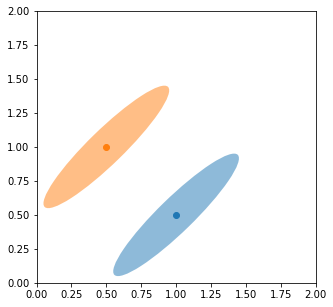

In [4]:
plot_elipses(mu0, sigma0, mu1, sigma1)

In [57]:
draws = 10000
LD_samples = 10000
new = []
old = []
sigma0s = []
sigma1s = []

for ii in range(draws):
    a0 = 2. * np.pi * np.random.rand()
    R0 = np.array([[np.cos(a0), np.sin(a0)], [-np.sin(a0), np.cos(a0)]])
    sigma0_p = R0.dot(sigma0).dot(R0.T)
    a1 = 2. * np.pi * np.random.rand()
    R1 = np.array([[np.cos(a1), np.sin(a1)], [-np.sin(a1), np.cos(a1)]])
    sigma1_p = R1.dot(sigma1).dot(R1.T)
    new.append(mv_normal_jeffreys(mu0, sigma1_p, mu1, sigma1_p))
    x0 = np.random.multivariate_normal(mu0, sigma0_p, size=LD_samples)
    x1 = np.random.multivariate_normal(mu1, sigma1_p, size=LD_samples)
    old.append(linear_discriminability_data(x0, x1))
    sigma0s.append(sigma0_p)
    sigma1s.append(sigma1_p)
new = np.array(new)
idxs = np.argsort(new)
new = new[idxs]
old = np.array(old)[idxs]

new_percentile = np.zeros_like(new)
old_percentile = np.zeros_like(old)
for ii in range(draws):
    new_percentile[ii] = percentileofscore(new, new[ii])
    old_percentile[ii] = percentileofscore(old, old[ii])

Red dot
KL: 0.9999413044719421, 99.42999999999999th percentile over all configurations
LD: 0.5374126056981773, 26.009999999999998th percentile over all configurations


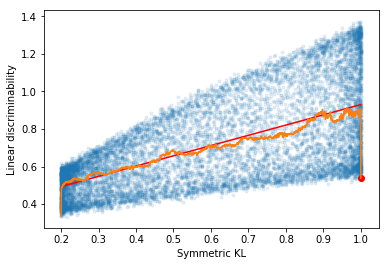

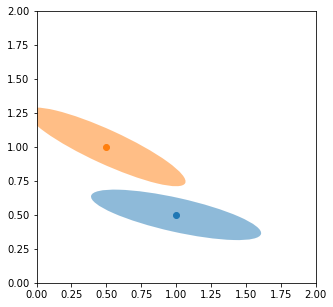

In [58]:
f = plt.figure()
plt.scatter(new, old, marker='.', alpha=.1)
model = LinearRegression().fit(new[:,np.newaxis], old[:,np.newaxis])
xmin = new.min()
xmax = new.max()
m = np.squeeze(model.coef_)
b = np.squeeze(model.intercept_)
plt.plot([xmin, xmax], [m * xmin + b, m * xmax + b], 'r')
plt.plot(new, medfilt(old, 501), c=u'#ff7f0e')
plt.xlabel('Symmetric KL')
plt.ylabel('Linear discriminability')

idx = abs(old_percentile - new_percentile).argmax()
plt.scatter(new[idx], old[idx], c='r')

f = plt.figure()
plot_elipses(mu0, sigma0s[idx], mu1, sigma1s[idx])
print('Red dot')
print("KL: {}, {}th percentile over all configurations".format(new[idx], percentileofscore(new, new[idx])))
print("LD: {}, {}th percentile over all configurations".format(old[idx], percentileofscore(old, old[idx])))